## Reprojecting MODSCAG Data 11/15/2018

In [1]:
import gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = r"C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/1.13.2014/MOD09GA.A2014013.h09v05.005.2014015123811.snow_fraction.tif"
input_raster = gdal.Open(filename)
output_raster = r"C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/1.13.2014/MOD09GA.1132014.reproject.tif"
gdal.Warp(output_raster,input_raster,dstSRS='+proj=utm +zone=13 +datum=WGS84')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015BA3B5C960> >

In [3]:
grid_filename = "C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/1.13.2014/MOD09GA.1132014.reproject.tif"

In [4]:
gfid = gdal.Open(grid_filename)
data = gfid.ReadAsArray()
data = np.float64(data)

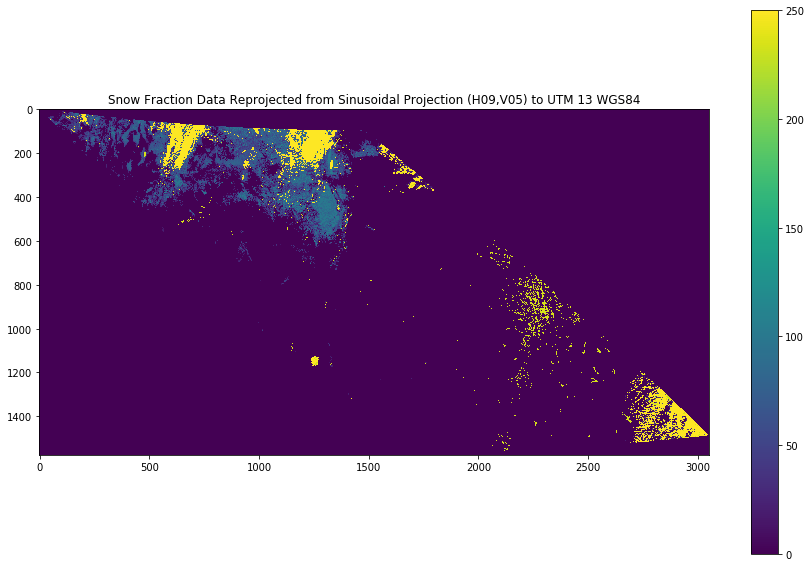

In [5]:
plt.figure(figsize=(15,10))
plt.imshow(data)
plt.title('Snow Fraction Data Reprojected from Sinusoidal Projection (H09,V05) to UTM 13 WGS84')
plt.colorbar()

Values between 0-100 indicate fractional snowcover (although no data is currently showing this color as well).
Values of 250 indicate thick clouds. The next step will be to subset this image to the East River Watershed boundary.

## Subsetting MODSCAG Data 11/29/2018

In [6]:
import gdalnumeric, ogr
from PIL import Image, ImageDraw

In [7]:
input_raster = "C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/5.1.2014/MODSCAG_EastRiver_SnowFraction_5.1.2014_Reproject.tif"
shp = "EastRiver_Project"
output_raster = "MODSCAG.5.1.Clip"

In [8]:
def imageToArray(i):
    a = gdalnumeric.fromstring(i.tostring(),'b')
    a.shape = i.im.size[1], i.im.size[0]
    return a

In [9]:
def world2Pixel(geoMatrix, x,y):
    ulY = geoMatrix[0]
    ulY = geoMatrix[3]
    xDist = geoMatrix[1]
    yDist = geoMatrix[5]
    rtnX = geoMatrix[2]
    rtnY = geoMatrix[4]
    pixel = int((x-ulX) / xDist)
    line = int((ulY - y) / yDist)
    return (pixel, line)

In [10]:
# Load the source data as a gdalnumeric array
srcArray = gdalnumeric.LoadFile(input_raster)

In [11]:
# Load as a gdal image to get geotransform (world file) info
scrImage = gdal.Open(input_raster)
geoTrans = scrImage.GetGeoTransform()


In [12]:
shapef = ogr.Open("%s.shp" % shp)
lyr = shapef.GetLayer(shp)
poly = lyr.GetNextFeature()

AttributeError: 'NoneType' object has no attribute 'GetLayer'

This is where the code is currently breaking.

In [ ]:
#Convert the layer extent to image pixel coordinates
minX, maxX, minY, maxY = lyr.GetExtent()
ulX, ulY = world2Pixel(geoTrans, minX, maxY)
lrX, lrY = world2Pixel(geoTrans, maxX, minY)

In [ ]:
# Calculate the pixel size of the new image
pxWidth = int(lrX - ulX)
pxHeight = int(lrY - ulY)

In [ ]:
# Multi-band image
clip = srcArray[:, ulY:lrY, ulX:lrX]

In [ ]:
# Create a new geomatrix for the image
geoTrans = list(geoTrans)
geoTrans[0] = minX
geoTrans[3] = maxY

In [ ]:
# Map points to pixels for drawing 
points = []
pixels = []
geom = poly.GetGeometryRef()
pts = geom.GetGeometryRef(0)
for p in range(pts.GetPointCount()):
  points.append((pts.GetX(p), pts.GetY(p)))
for p in points:
  pixels.append(world2Pixel(geoTrans, p[0], p[1]))
rasterPoly = Image.new("L", (pxWidth, pxHeight), 1)
rasterize = ImageDraw.Draw(rasterPoly)
rasterize.polygon(pixels, 0)
mask = imageToArray(rasterPoly)  

In [ ]:
clip = gdalnumeric.choose(mask, \
    (clip, 0)).astype(gdalnumeric.uint8)

In [ ]:
gdalnumeric.SaveArray(clip, output_raster, \
    format = "GTiff", prototype = input_raster)

Project Steps completed so far:
1. The dates of 5.1.2014 and 6.15.2014 were chosen for analysis. The year of 2014 had a slightly higher than average total SWE value, which means that there was likely enough snow cover around until late spring (e.g. May or June) to perform an anaysis of the difference in representation of the patchiness of SCA between the two MODIS products. The dates of 5/1 and 6/15 were chosen because they are late in the snow season and had a general lack of cloud cover.
2. MODSCAG geotiff files representing snow fraction data for the above dates were reprojected from sinusoidal projection to UTM 13 WSG84. For the selected dates, bands 4 and 6 from the MCD43A4 dataset were reprojected and reformatted from .hdf files to geotiff files. 
3. The next step currently in progress is to subset the data from 2 to the East River watershed boundary. The code for this is written above, however there are a few bugs to still be worked out. Once this is complete, NDSI data can be calculated from the MCD43A4 data bands 4 and 6. Finally, MODSCAG snow fraction and MDC43A4 NDSI values will be compared. 